In [102]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Data exploration and cleaning

In [142]:
data = pd.read_csv("data/fitness.csv")
data.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [143]:
data.day_of_week = ["Fri" if x == "Fri." else x for x in data.day_of_week]
data.day_of_week = ["Mon" if x == "Monday" else x for x in data.day_of_week]
data.day_of_week = ["Wed" if x == "Wednesday" else x for x in data.day_of_week]
data.category = [np.NaN if x == "-" else x for x in data.category] 
data.days_before = [x.strip(" days") for x in data.days_before] 
data["days_before"] = data["days_before"].astype(int)
data.time = [1 if x == "AM" else 0 for x in data.time]
data = data.dropna()

In [144]:
data

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,0,Strength,0
1,2,10,79.01,2,Mon,1,HIIT,0
2,3,16,74.53,14,Sun,1,Strength,0
3,4,5,86.12,10,Fri,1,Cycling,0
4,5,15,69.29,8,Thu,1,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,1,HIIT,0
1496,1497,29,89.55,2,Mon,1,Strength,0
1497,1498,9,87.38,4,Tue,1,HIIT,0
1498,1499,34,68.64,14,Sun,1,Aqua,0


# Data prep

In [145]:
# Selecting features and target
features = data.drop(columns=["booking_id", "attended"])
target = data[["attended"]]

In [146]:
features = features.reset_index(drop=True)

In [147]:
features

,months_as_member,weight,days_before,day_of_week,time,category
0,17,79.56,8,Wed,0,Strength
1,10,79.01,2,Mon,1,HIIT
2,16,74.53,14,Sun,1,Strength
3,5,86.12,10,Fri,1,Cycling
4,15,69.29,8,Thu,1,HIIT
...,...,...,...,...,...,...
1462,21,79.51,10,Fri,1,HIIT
1463,29,89.55,2,Mon,1,Strength
1464,9,87.38,4,Tue,1,HIIT
1465,34,68.64,14,Sun,1,Aqua


## Encoding

In [148]:
# Encoding the day_of_week column
def encode_day_of_week(features):
    ohe_day = OneHotEncoder(sparse= False, handle_unknown='ignore')
    ohe_day.fit_transform(features[["day_of_week"]])
    day_of_week_encoded = pd.DataFrame(ohe_day.fit_transform(features[["day_of_week"]]), columns=ohe_day.categories_).reset_index(drop=True)
    df = pd.concat([features, day_of_week_encoded], axis=1)
    return df, ohe_day

In [149]:
# Encoding the category column
def encode_features(features):
    df = encode_day_of_week(features)[0]
    ohe_day = encode_day_of_week(features)[1]
    ohe_category = OneHotEncoder(sparse= False, handle_unknown='ignore')
    feature_to_encode = features[["category"]]
    ohe_category.fit_transform(feature_to_encode)
    category_encoded = pd.DataFrame(ohe_category.fit_transform(feature_to_encode), columns=ohe_category.categories_).reset_index(drop=True)
    features_encoded = pd.concat([df, category_encoded], axis=1)
    return features_encoded.drop(columns=["day_of_week", "category"]), ohe_day, ohe_category

In [180]:
features_encoded, ohe_day, ohe_category = encode_features(features)
features_encoded

,months_as_member,weight,days_before,time,"(Fri,)","(Mon,)","(Sat,)","(Sun,)","(Thu,)","(Tue,)","(Wed,)","(Aqua,)","(Cycling,)","(HIIT,)","(Strength,)","(Yoga,)"
0,17,79.56,8,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,10,79.01,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,16,74.53,14,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,86.12,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,15,69.29,8,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,21,79.51,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1463,29,89.55,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1464,9,87.38,4,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1465,34,68.64,14,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [151]:
# Train test split must occur BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.10, random_state=42)

## Feature scaling

In [152]:
X_train = X_train.reset_index(drop=True)

In [153]:
def scale_and_return_scaler(X_train):
    transformer = RobustScaler()
    df_scaled = transformer.fit_transform(X_train.iloc[:, 0:3].to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=["months_scaled", "weight_scaled", "days_scaled"])
    return pd.concat([df_scaled, X_train.iloc[:, 3:]], axis=1), transformer

In [154]:
X_train_scaled, scaler = scale_and_return_scaler(X_train)

### Must now tranform test set using fitted scaler

In [157]:
X_test = X_test.reset_index(drop=True)

In [158]:
X_test

,months_as_member,weight,days_before,time,"(Fri,)","(Mon,)","(Sat,)","(Sun,)","(Thu,)","(Tue,)","(Wed,)","(Aqua,)","(Cycling,)","(HIIT,)","(Strength,)","(Yoga,)"
0,3,90.34,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,8,92.84,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,97.16,4,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9,82.13,10,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,48,68.39,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,33,71.25,11,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
143,9,112.15,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
144,2,103.20,12,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145,7,89.22,9,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [159]:
X_test_scaled = scaler.transform(X_test.iloc[:, 0:3].to_numpy())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=["months_scaled", "weight_scaled", "days_scaled"])
X_test.months_as_member = X_test_scaled.months_scaled
X_test.weight = X_test_scaled.weight_scaled
X_test.days_before = X_test_scaled.days_scaled

In [160]:
X_test

,months_as_member,weight,days_before,time,"(Fri,)","(Mon,)","(Sat,)","(Sun,)","(Thu,)","(Tue,)","(Wed,)","(Aqua,)","(Cycling,)","(HIIT,)","(Strength,)","(Yoga,)"
0,-0.818182,0.597411,0.125,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.363636,0.753393,0.125,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.727273,1.022929,-0.625,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.272727,0.085166,0.125,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.272727,-0.772110,0.125,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,1.909091,-0.593667,0.250,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
143,-0.272727,1.958197,0.125,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
144,-0.909091,1.399782,0.375,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145,-0.454545,0.527531,0.000,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Re-balancing

Less than 30% of all records are 1 (dataset is quite imbalanced)

In [161]:
# Creating an instance of SMOTE
smote = SMOTE()

# Balancing the data
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Classification

## Baseline logistic regression

Accuracy: 0.782312925170068
F1 Score: 0.6444444444444444
Recall: 0.6904761904761905
Precision: 0.6041666666666666
Confusion Matrix:
 [[86 19]
 [13 29]]


<AxesSubplot:>

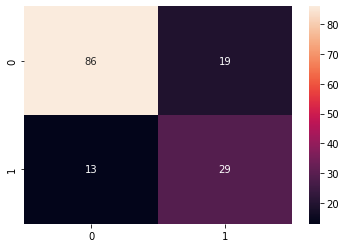

In [96]:
# LBFGS solver
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_resampled, y_resampled)
y_true = y_test
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
      
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

## Support Vector Machine

In [196]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_resampled, y_resampled)
y_true = y_test
y_pred = svc.predict(X_test)
print("Accuracy:", svc.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.7619047619047619
F1 Score: 0.6464646464646465
Recall: 0.7619047619047619
Precision: 0.5614035087719298
Confusion Matrix:
 [[80 25]
 [10 32]]


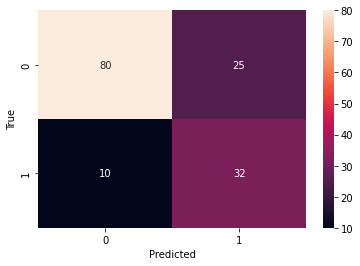

In [219]:
fig = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("True");

## Random Forest Classifier

In [95]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_resampled, y_resampled)
y_true = y_test
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.7346938775510204
F1 Score: 0.6213592233009708
Recall: 0.7619047619047619
Precision: 0.5245901639344263
Confusion Matrix:
 [[76 29]
 [10 32]]


<AxesSubplot:>

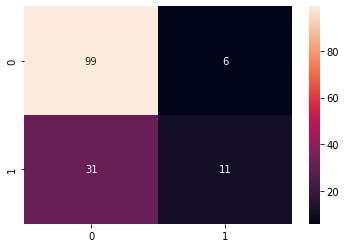

In [36]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

## Gradient Boosting Classifier

Accuracy: 0.7482993197278912
F1 Score: 0.6105263157894737
Recall: 0.6904761904761905
Precision: 0.5471698113207547
Confusion Matrix:
 [[81 24]
 [13 29]]


<AxesSubplot:>

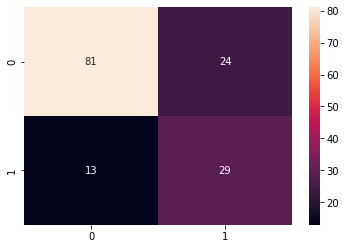

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_resampled, y_resampled)
y_true = y_test
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

### Gridsearch of Random Forest

In [98]:
parameters = {'n_estimators': np.linspace(10,200,10,dtype=int), 'min_samples_split':[2, 4, 6, 8],
              'min_samples_leaf':[1, 2, 3, 4], 'max_depth':[1, 2, 3, 4, 5]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters)
clf.fit(X_resampled, y_resampled)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': array([ 10,  31,  52,  73,  94, 115, 136, 157, 178, 200])})

In [99]:
clf.best_params_

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 73}

Accuracy: 0.7619047619047619
F1 Score: 0.5070422535211268
RECALL: 0.42857142857142855
Precision: 0.6206896551724138
Confusion Matrix:
 [[94 11]
 [24 18]]


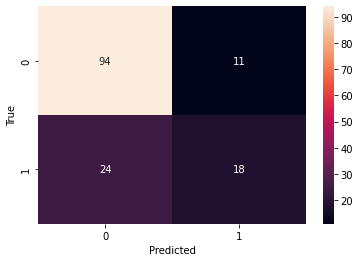

In [100]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=73)
rf.fit(X_resampled, y_resampled)
y_true = y_test
y_pred = svc.predict(X_test)
print("Accuracy:", svc.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("RECALL:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
fig = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("True");

# Grid searches

### Gridsearch for SVC

In [79]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 10, 20, 50]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_resampled, y_resampled)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 20, 50],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [80]:
clf.best_params_

{'C': 20, 'kernel': 'rbf'}

Accuracy: 0.7619047619047619
F1 Score: 0.5070422535211268
RECALL: 0.42857142857142855
Precision: 0.6206896551724138
Confusion Matrix:
 [[94 11]
 [24 18]]


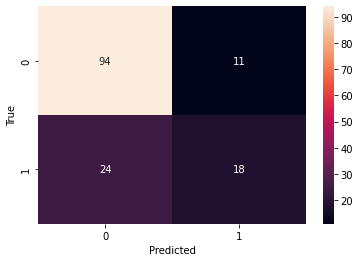

In [81]:
svc = SVC(C=20, kernel='rbf')
svc.fit(X_resampled, y_resampled)
y_true = y_test
y_pred = svc.predict(X_test)
print("Accuracy:", svc.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("RECALL:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
fig = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("True");

**Precision is a good measure to determine, when the costs of False Positive is high.**</br>
**Recall is a good measure to determine when the cost of False Negative is high**</br>
In the case of our task, we want to minimize the occurence of False Negatives. This is because if the model predicts that a customer will not attend, then leaving a spot open for someone else, yet the customer attends, there will be over-booking, and not enough space for at least one customer.

### Gridsearch of Gradient Boosting model

In [90]:
parameters = {"n_estimators": np.linspace(40,55,5,dtype=int), "learning_rate": np.linspace(1,2,5,dtype=int), "max_depth": np.linspace(5,15,5,dtype=int)}
gbc = GradientBoostingClassifier()
clf = GridSearchCV(gbc, parameters)
clf.fit(X_resampled, y_resampled)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([1, 1, 1, 1, 2]),
                         'max_depth': array([ 5,  7, 10, 12, 15]),
                         'n_estimators': array([40, 43, 47, 51, 55])})

In [91]:
clf.best_params_

{'learning_rate': 1, 'max_depth': 12, 'n_estimators': 47}

Accuracy: 0.7619047619047619
F1 Score: 0.6153846153846153
RECALL: 0.6666666666666666
Precision: 0.5714285714285714
Confusion Matrix:
 [[84 21]
 [14 28]]


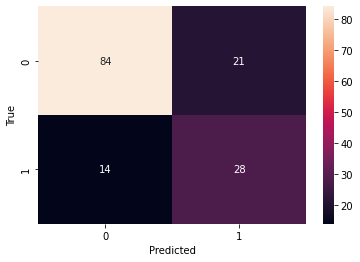

In [93]:
gbc = GradientBoostingClassifier(learning_rate=1, max_depth=12, n_estimators=47)
gbc.fit(X_resampled, y_resampled)
y_true = y_test
y_pred = gbc.predict(X_test)
print("Accuracy:", gbc.score(X_test, y_test))
print("F1 Score:", f1_score(y_true, y_pred))
print("RECALL:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
fig = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("True");

# Predict new  data with a trained model

In [189]:
def transform_new_data(data_to_predict, scaler, ohe_day, ohe_category):
    new_data = pd.DataFrame(data_to_predict, columns = ["months_as_member", "weight", "days_before", "day_of_week", "time", "category"])
    ohe_day.transform(new_data[["day_of_week"]])
    day_of_week_encoded = pd.DataFrame(ohe_day.transform(new_data[["day_of_week"]]), columns=ohe_day.categories_).reset_index(drop=True)
    #print(day_of_week_encoded)
    df = pd.concat([new_data, day_of_week_encoded], axis=1)
    category_encoded = pd.DataFrame(ohe_category.transform(new_data[["category"]]), columns=ohe_category.categories_).reset_index(drop=True)
    #print(category_encoded)
    features_encoded = pd.concat([df, category_encoded], axis=1)
    #print(features_encoded)
    df_encoded = features_encoded.drop(columns=["day_of_week", "category"])
    df_scaled = scaler.transform(df_encoded.iloc[:, 0:3].to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=["months_scaled", "weight_scaled", "days_scaled"])
    df_encoded["months_as_member"] = df_scaled["months_scaled"]
    df_encoded["weight"] = df_scaled["weight_scaled"]
    df_encoded["days_before"] = df_scaled["days_scaled"]
    return df_encoded
    

In [190]:
data_to_predict = [["9", "73.52", "4", "Wed", "1", "Strength"]]

In [191]:
transform_new_data(data_to_predict, scaler, ohe_day, ohe_category)

,months_as_member,weight,days_before,time,"(Fri,)","(Mon,)","(Sat,)","(Sun,)","(Thu,)","(Tue,)","(Wed,)","(Aqua,)","(Cycling,)","(HIIT,)","(Strength,)","(Yoga,)"
0,-0.272727,-0.452036,-0.625,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Make predictions

In [192]:
data_to_predict = [["9", "73.52", "4", "Wed", "1", "Strength"]]
data_transformed = transform_new_data(data_to_predict, scaler, ohe_day, ohe_category)

In [193]:
svc.predict(data_transformed)

array([0])

In [197]:
svc.predict_proba(data_transformed)

array([[0.90941905, 0.09058095]])

In [198]:
data_to_predict = [["14", "93.52", "2", "Fri", "0", "HIIT"]]
data_transformed = transform_new_data(data_to_predict, scaler, ohe_day, ohe_category)
print(svc.predict(data_transformed))
print(svc.predict_proba(data_transformed))

[1]
[[0.29154231 0.70845769]]


Could set a probability threshold of 70%, beyond which the prediction is accepted.

# How much does this model benefit GoalZone?

In [199]:
data

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,0,Strength,0
1,2,10,79.01,2,Mon,1,HIIT,0
2,3,16,74.53,14,Sun,1,Strength,0
3,4,5,86.12,10,Fri,1,Cycling,0
4,5,15,69.29,8,Thu,1,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,1,HIIT,0
1496,1497,29,89.55,2,Mon,1,Strength,0
1497,1498,9,87.38,4,Tue,1,HIIT,0
1498,1499,34,68.64,14,Sun,1,Aqua,0


In [200]:
px.histogram(data, x="category", color="attended")

In [215]:
attendance_per_category = data.groupby(["category", "attended"], as_index=False).count()
attendance_per_category

,category,attended,booking_id,months_as_member,weight,days_before,day_of_week,time
0,Aqua,0,49,49,49,49,49,49
1,Aqua,1,25,25,25,25,25,25
2,Cycling,0,262,262,262,262,262,262
3,Cycling,1,108,108,108,108,108,108
4,HIIT,0,447,447,447,447,447,447
5,HIIT,1,210,210,210,210,210,210
6,Strength,0,169,169,169,169,169,169
7,Strength,1,62,62,62,62,62,62
8,Yoga,0,93,93,93,93,93,93
9,Yoga,1,42,42,42,42,42,42


In [218]:
for category in ["Aqua", "Cycling", "HIIT", "Strength", "Yoga"]:
    df_filtered = attendance_per_category[attendance_per_category["category"] == category]
    absence_ratio = df_filtered[df_filtered["attended"] == 0]["booking_id"].values[0] / (df_filtered[df_filtered["attended"] == 0]["booking_id"].values[0] + df_filtered[df_filtered["attended"] == 1]["booking_id"].values[0])
    print(f"The absence ratio for {category} is {absence_ratio}")

The absence ratio for Aqua is 0.6621621621621622
The absence ratio for Cycling is 0.7081081081081081
The absence ratio for HIIT is 0.680365296803653
The absence ratio for Strength is 0.7316017316017316
The absence ratio for Yoga is 0.6888888888888889


* Since the model has an accuracy of ~ 76%, then it will correctly identify 76% of absences, potentially reducing absences by 76%.</br></br>
* However, the model soemtimes wrongly classifies as not attending when in fact the customer will attend. Those wrong "not attending" classifications represent ~10% of all "not attending" classifications, thus increasing the risk of overbooking. </br></br>
* However, when looking at the absence ratios for each class category (hovering between 66 and 73%), the risk of overbooking is very limited.Those wrong "not attending" classifications will most likely not result in overbooking, rather it will reduce the benefits of the model by about 10%.

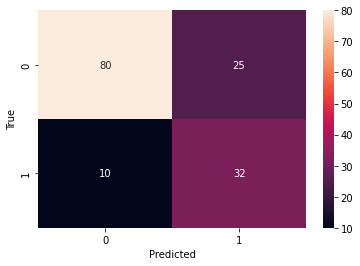

In [220]:
fig = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("True");

For a class of 100 capacity that is fully booked (i.e. received 100 bookings), on average 68 will not attend.</br>
Out of those 68, the model will correctly identify 52 (precision). Thus liberating 52 spots for other people to book.

However, among the 32 attending, the model will classify 8 as not attending (1-recall). Thus liberating an extra 8 spots.

So in total, instead of liberating 68 spots, the model will liberate only 60 for other people to book.

Eventually, reducing the non-attendance by 88%.